In [1]:
import gpfanova, scipy

In [2]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [207]:
ds = gpfanova.dataset.DataSet('data/normalized/lund/propionicAcid-ecoli/')
ds.data = ds.data.iloc[3:,:]

# x,y,effect,labels = ds.build(effects=['pH','propionicAcidmM'],scale='range')
x,y,effect,labels = ds.build(effects=['pH','propionicAcidmM'])

# y = y + 1e-10
y[y<=0] = y[y>0].min()
# y = y/y[0,:]

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        select = (effect.values[:,0] == i) & (effect.values[:,1] == j)
        #y[:,select] -= y[:,select].min()
        y[:,select] /= y[0,select].mean()
        
y = np.log2(y+1e-9)
# y = np.log2(y+1e-9)
# y = y-y.min()
# y = (y-y.mean())/y.std()

(array([   2.,    0.,    0.,    6.,    5.,   15.,   28.,   48.,  111.,   37.]),
 array([-3.84130223, -3.36648295, -2.89166367, -2.41684438, -1.9420251 ,
        -1.46720582, -0.99238654, -0.51756725, -0.04274797,  0.43207131,
         0.9068906 ]),
 <a list of 10 Patch objects>)

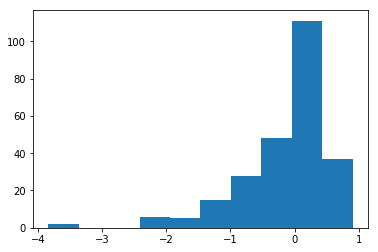

In [208]:
plt.hist(y[0,:])

In [209]:
select = y[0,:] < -1
y[:,select] -= y[0,select]

(array([ 13.,  10.,  12.,  19.,  23.,  62.,  51.,  41.,  14.,   7.]),
 array([-0.99426363, -0.80414821, -0.61403278, -0.42391736, -0.23380194,
        -0.04368652,  0.14642891,  0.33654433,  0.52665975,  0.71677517,
         0.9068906 ]),
 <a list of 10 Patch objects>)

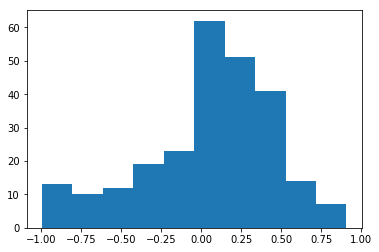

In [210]:
plt.hist(y[0,:])

In [211]:
y[:,np.any(y<-2,0)] = np.nan

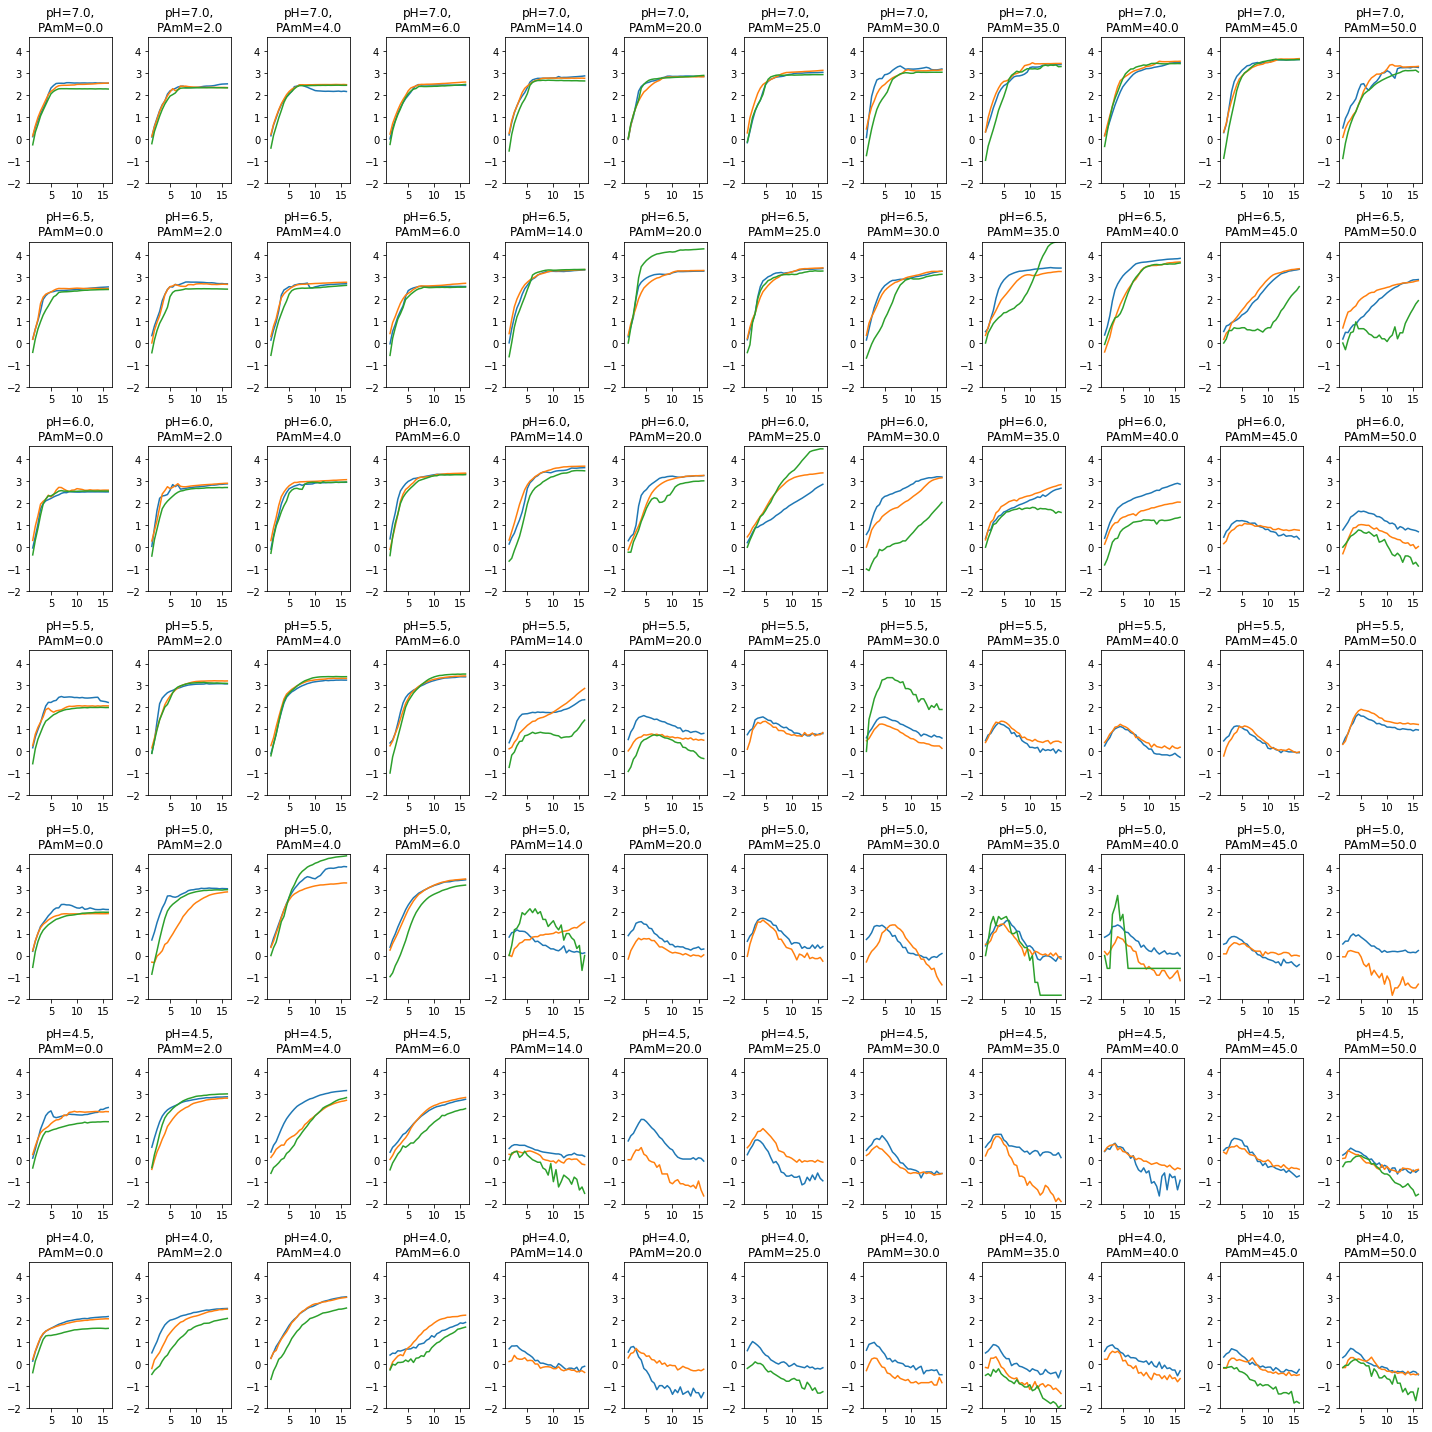

In [259]:
plt.figure(figsize=(20,20))

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        plt.title("pH=%s,\nPAmM=%s"%(labels[0][i],labels[1][j]))
        select = (effect.values[:,0] == i) & (effect.values[:,1] == j)
        plt.plot(x,y[:,select]);
        
        #plt.semilogy()
        plt.ylim(np.nanmin(y),np.nanmax(y))
        #plt.yticks(2.**(np.arange(5)-2))
        
plt.tight_layout()

plt.savefig("figures/lund/ecoli.pdf",dpi=300,bbox_inches='tight')

In [213]:
import GPy
from GPy.kern import RBF, Integral

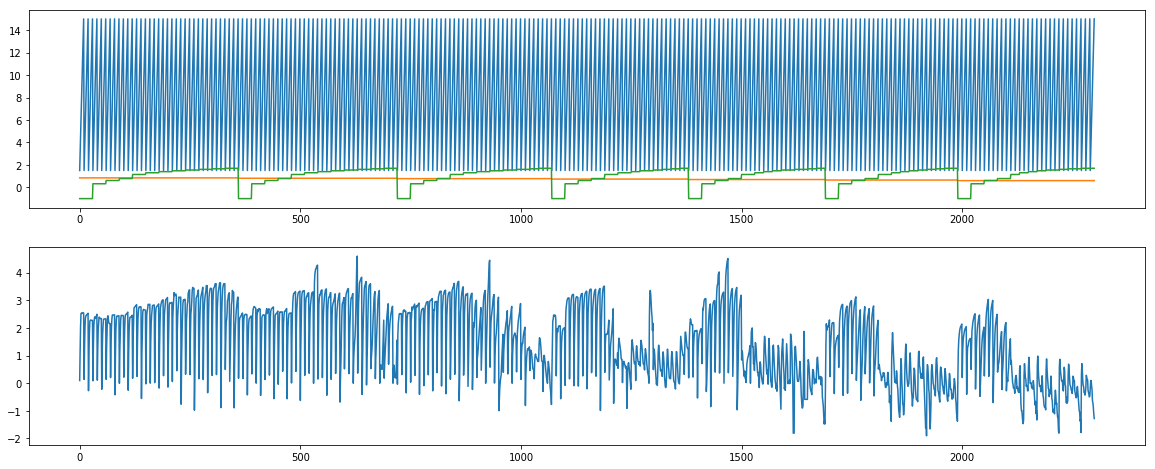

In [254]:
xgp = np.zeros((x.shape[0]*y.shape[1], 3))
xgp[:,0] = np.tile(x[:,0],y.shape[1])

# pH
xgp[:,1] = np.log10(np.repeat(ds.meta.pH, x.shape[0]))

# acid
xgp[:,2] = np.log10(np.repeat(ds.meta.propionicAcidmM, x.shape[0])+1e-1)

ygp = y.ravel(1)

xgp = xgp[::3,:]
ygp = ygp[::3]

select = np.isnan(ygp)

ygp = ygp[~select][:,None]
xgp = xgp[~select,:]

plt.figure(figsize=(20,8))

plt.subplot(211)
plt.plot(xgp)

plt.subplot(212)
plt.plot(ygp)

In [215]:
kern = RBF(1, name='mean') + RBF(2,active_dims=[0,1],name='pH',ARD=True) + RBF(2,active_dims=[0,2],name='PA',ARD=True)
kern = RBF(3, ARD=True)

kern

In [216]:
gp = GPy.models.GPRegression(xgp,ygp,kern)
gp

In [217]:
gp.optimize()
gp

In [218]:
xpred = np.zeros((50,3))
xpred[:,0] = np.linspace(x.min(),x.max())
# xpred[:,1:] = 0.84509804, -1.
# xpred[:,1:] = 0.60205999,  1.69983773

# mu,cov = gp.predict(xpred,full_cov=True)
# mu = mu[:,0]

# std = np.sqrt(cov.diagonal())

# plt.plot(xpred[:,0],mu)
# plt.fill_between(xpred[:,0], mu-2*std, mu+2*std,alpha=.1)

In [220]:
ds.meta.pH.unique()

array([ 7. ,  6.5,  6. ,  5.5,  5. ,  4.5,  4. ])

In [229]:
g = ds.meta.groupby(['pH','propionicAcidmM'])

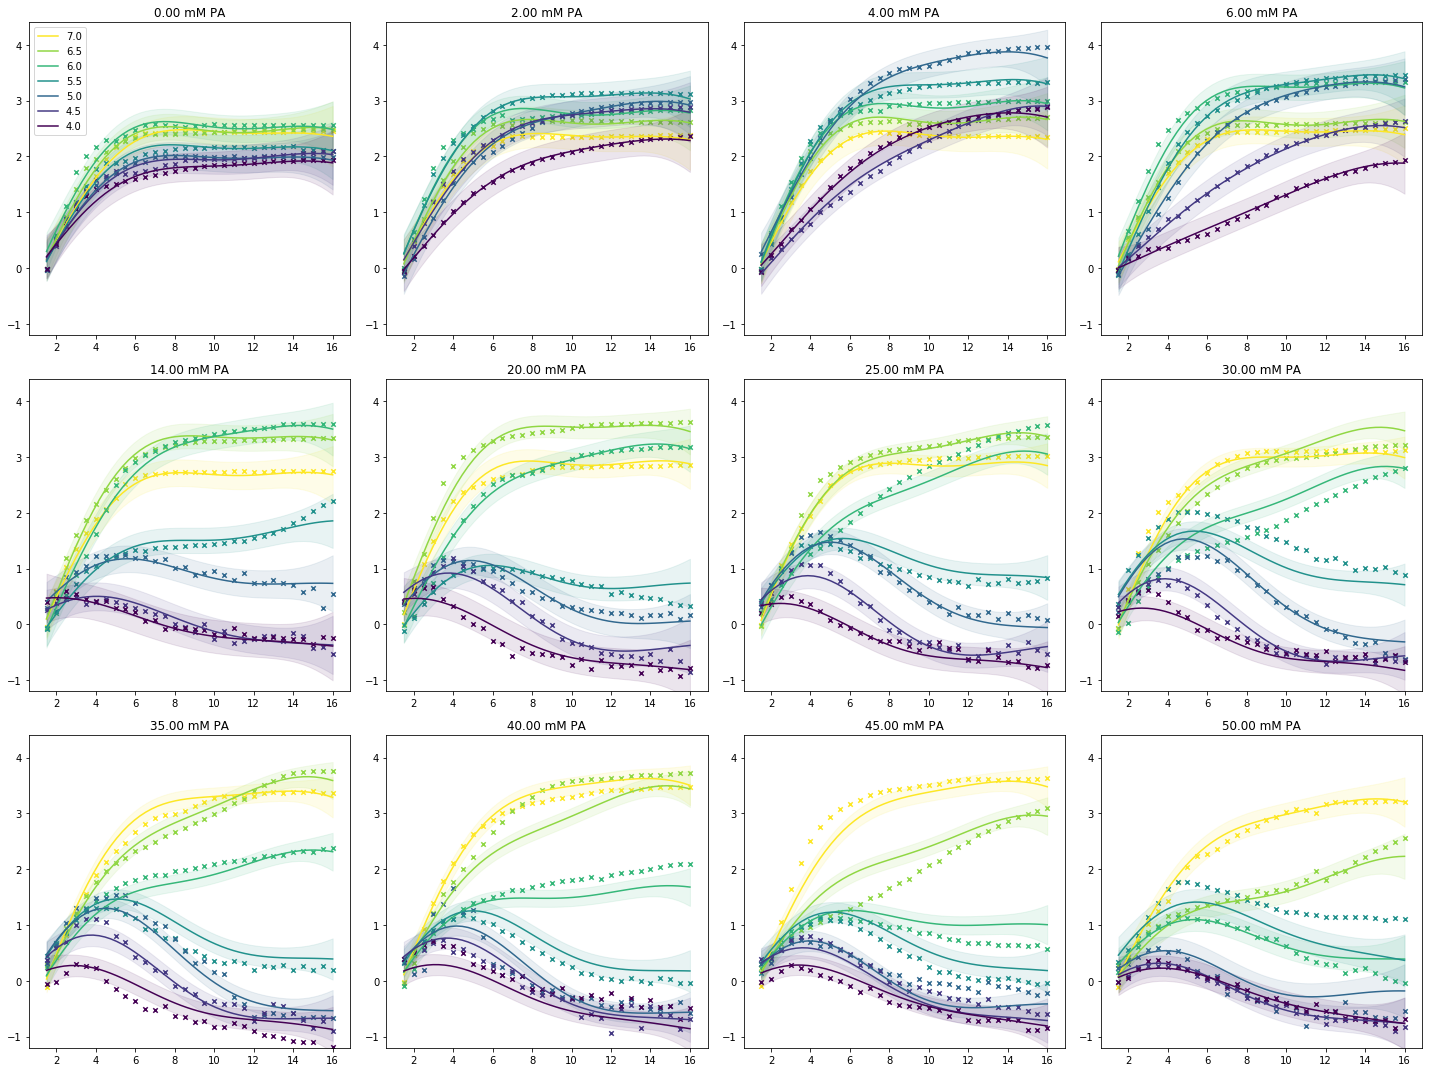

In [266]:
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, ds.meta.pH.unique().shape[0]*5))
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, 5))
plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5./3, 5*3))

for i,ph in enumerate(np.log10(ds.meta.pH.unique())):
    for j,pa in enumerate(np.log10(ds.meta.propionicAcidmM.unique() + 1e-1)):
        
        #plt.subplot(ds.meta.pH.unique().shape[0], ds.meta.propionicAcidmM.unique().shape[0], i*ds.meta.propionicAcidmM.unique().shape[0] +j + 1)
        
        #plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], j + 1)
        plt.subplot(3, 1.*ds.meta.propionicAcidmM.unique().shape[0]/3, j + 1)
        
        #plt.title(((10**ph).round(), (10**pa-1e-1).round()))
        plt.title("%.2lf mM PA"%((10**pa)-1e-1))
        
        xpred[:,1:] = ph, pa

        mu,cov = gp.predict_noiseless(xpred,full_cov=True)
        mu = mu[:,0]

        std = np.sqrt(cov.diagonal())
        
        color = plt.get_cmap()(((10.**ph)-4)/3)

        plt.plot(xpred[:,0],mu, label = np.round(10**ph,1),c=color)
        plt.fill_between(xpred[:,0], mu-2*std, mu+2*std,alpha=.1,color=color)
        
        #ph = np.round(10**ph,2)
        #pa = np.round(10**pa-1e-1,2)
        
        #ph, pa = 10**ph, 10**pa -1e-1
        pa = np.round(10**pa - 1e-1,2)
        
        select = g.get_group((np.round(10**ph,2),pa)).index
        
        plt.scatter(x,np.nanmean(y[:,select],1),c=color,marker='x',s=20)
        #plt.errorbar(x,np.nanmean(y[:,select],1), np.nanstd(y[:,select],1),c=color)
        
        plt.ylim(-1.2,4.4)
        
# plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], 1)
plt.subplot(3, 1.*ds.meta.propionicAcidmM.unique().shape[0]/3,1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("figures/lund/ecoli-gp-byPA.pdf",bbox_inches='tight')

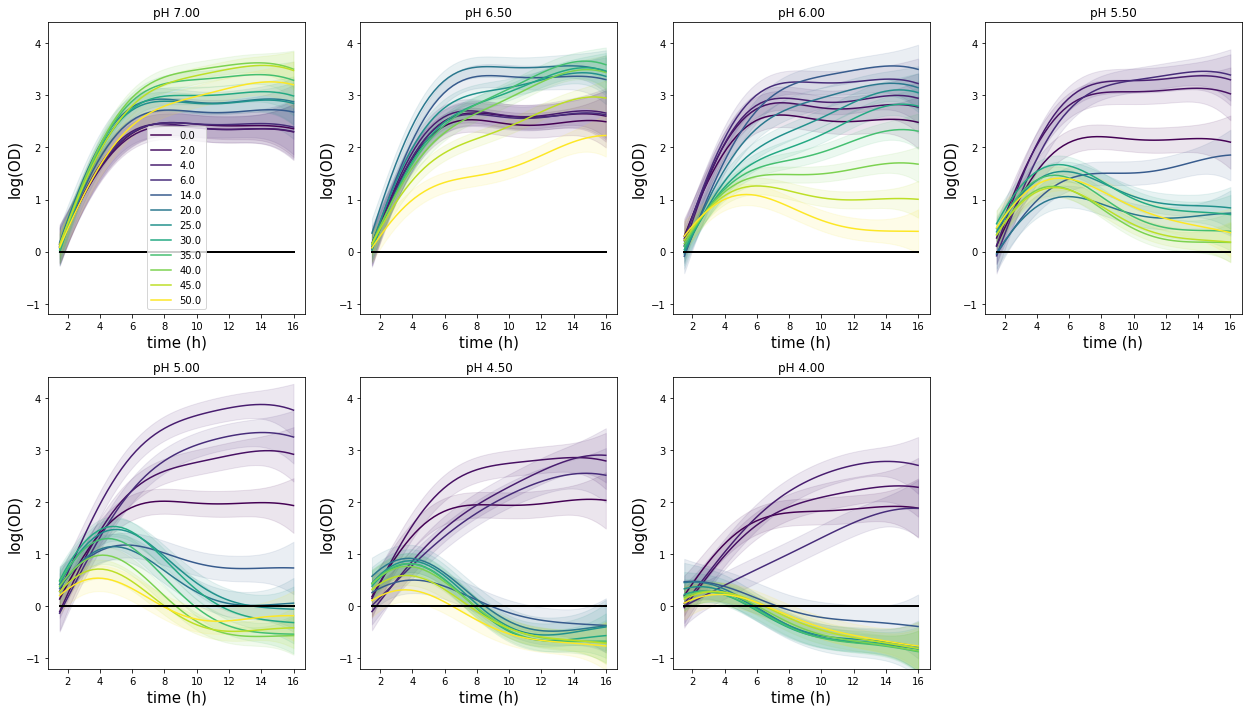

In [278]:
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, ds.meta.pH.unique().shape[0]*5))
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, 5))

nrow = 2
plt.figure(figsize=(ds.meta.pH.unique().shape[0]*5./nrow, 5*nrow))

for i,ph in enumerate(np.log10(ds.meta.pH.unique())):
    for j,pa in enumerate(np.log10(ds.meta.propionicAcidmM.unique() + 1e-1)):
        
        #plt.subplot(ds.meta.pH.unique().shape[0], ds.meta.propionicAcidmM.unique().shape[0], i*ds.meta.propionicAcidmM.unique().shape[0] +j + 1)
        
        #plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], j + 1)
        plt.subplot(nrow, ds.meta.pH.unique().shape[0]/nrow + 1, i + 1)
        
        #plt.title(((10**ph).round(), (10**pa-1e-1).round()))
        #plt.title((10**pa).round())
        plt.title("pH %.2lf"%((10**ph)))
        
        xpred[:,1:] = ph, pa

        mu,cov = gp.predict_noiseless(xpred,full_cov=True)
        mu = mu[:,0]

        std = np.sqrt(cov.diagonal())
        
        color = plt.get_cmap()(((10.**pa))/50)

        plt.plot(xpred[:,0],mu, label = np.round(10**pa - 1e-1,1),c=color)
        plt.fill_between(xpred[:,0], mu-2*std, mu+2*std,alpha=.1,color=color)
        plt.plot([x.min(), x.max()], [0,0], lw=2, c='k')
        plt.ylim(-1.2,4.4)        
        plt.ylabel("log(OD)",fontsize=15)
        plt.xlabel("time (h)",fontsize=15)
        
# plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], 1)
plt.subplot(nrow, ds.meta.pH.unique().shape[0]/nrow + 1, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("figures/lund/ecoli-gp-byPh.pdf",bbox_inches='tight')

In [224]:
class RBFDerivative(RBF):
    
    def K(self,X,X2):
        k = super(RBFDerivative, self).K(X,X2)
        if X2 is None:
            diff = np.zeros((X.shape[0],X.shape[0]))
            for i in range(X.shape[0]):
                for j in range(X.shape[0]):
                    diff[i,j] = X[i,0] - X[j,0]
                    #diff[i,j] = -X[i,0] + X[j,0]
            
            return (1./(self.lengthscale[0]))*(1-(1./(self.lengthscale[0]))*(diff**2))*k
            #return k * (-1./(self.lengthscale[0]))*diff
        else:
            #X2 is derivative obs
            
            diff = np.zeros((X.shape[0],X2.shape[0]))
            for i in range(X.shape[0]):
                for j in range(X2.shape[0]):
                    diff[i,j] = X[i,0] - X2[j,0]
                    #diff[i,j] = -X[i,0] + X[j,0]
                    
            return k * (1./(self.lengthscale[0]))*diff        
            #return (1./(self.lengthscale[0]))*(1-(1./(self.lengthscale[0]))*(diff**2))*k

In [225]:
kernDeriv = RBFDerivative(3, ARD=True, variance=kern.variance, lengthscale = kern.lengthscale)
kernDeriv

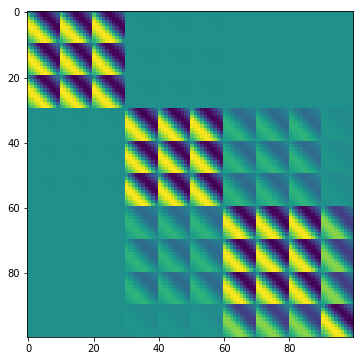

In [226]:
K = kernDeriv.K(xgp[:100,:], xgp[:100,:])

plt.figure(figsize=(6,6))
plt.imshow(K)

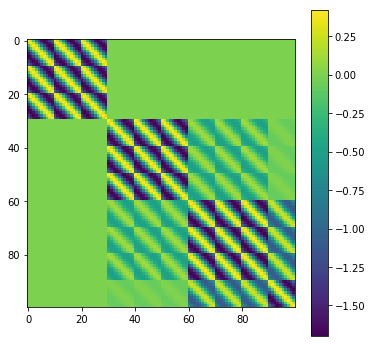

In [227]:
K = kernDeriv.K(xgp[:100,:])

plt.figure(figsize=(6,6))
plt.imshow(K)
plt.colorbar()

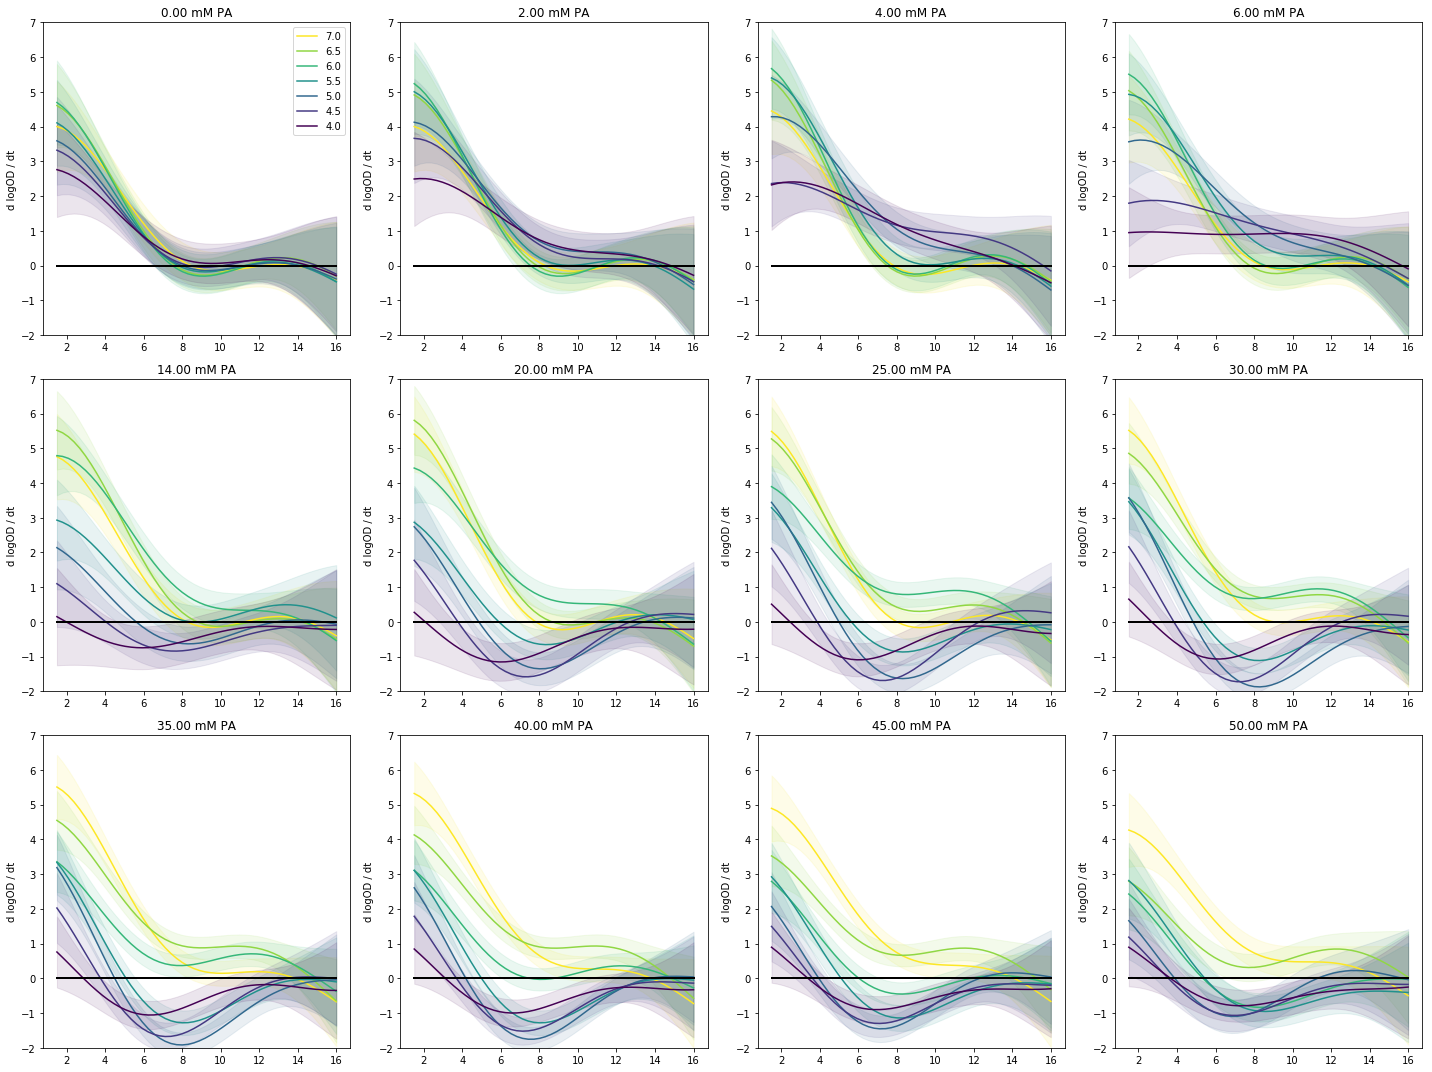

In [268]:
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, ds.meta.pH.unique().shape[0]*5))
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, 5))
plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5./3, 5*3))

for i,ph in enumerate(np.log10(ds.meta.pH.unique())):
    for j,pa in enumerate(np.log10(ds.meta.propionicAcidmM.unique() + 1e-1)):
        
        #plt.subplot(ds.meta.pH.unique().shape[0], ds.meta.propionicAcidmM.unique().shape[0], i*ds.meta.propionicAcidmM.unique().shape[0] +j + 1)
        
        #plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], j + 1)
        plt.subplot(3, 1.*ds.meta.propionicAcidmM.unique().shape[0]/3, j + 1)
        
        #plt.title(((10**ph).round(), (10**pa-1e-1).round()))
        #plt.title((10**pa).round())
        plt.title("%.2lf mM PA"%((10**pa)-1e-1))
        
        xpred[:,1:] = ph, pa

        mu,cov = gp.predict_noiseless(xpred,kern=kernDeriv,full_cov=False)
        mu = mu[:,0]#[:,0]
        
        #cov = cov-cov.min()
        cov = cov[:,0]
        #std = np.sqrt(cov.diagonal())
        std = np.sqrt(cov)
        
        color = plt.get_cmap()(((10.**ph)-4)/3)

        plt.plot(xpred[:,0],mu, label = np.round(10**ph,1),c=color)
        plt.fill_between(xpred[:,0], mu-2*std, mu+2*std,alpha=.1,color=color)
        plt.plot([x.min(), x.max()], [0,0], lw=2, c='k')
        plt.ylim(-2,7)
        plt.ylabel("d logOD / dt")
        
        
# plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], 1)
plt.subplot(3, 1.*ds.meta.propionicAcidmM.unique().shape[0]/3,1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("figures/lund/ecoli-gp-byPA-derivative.pdf",bbox_inches='tight')

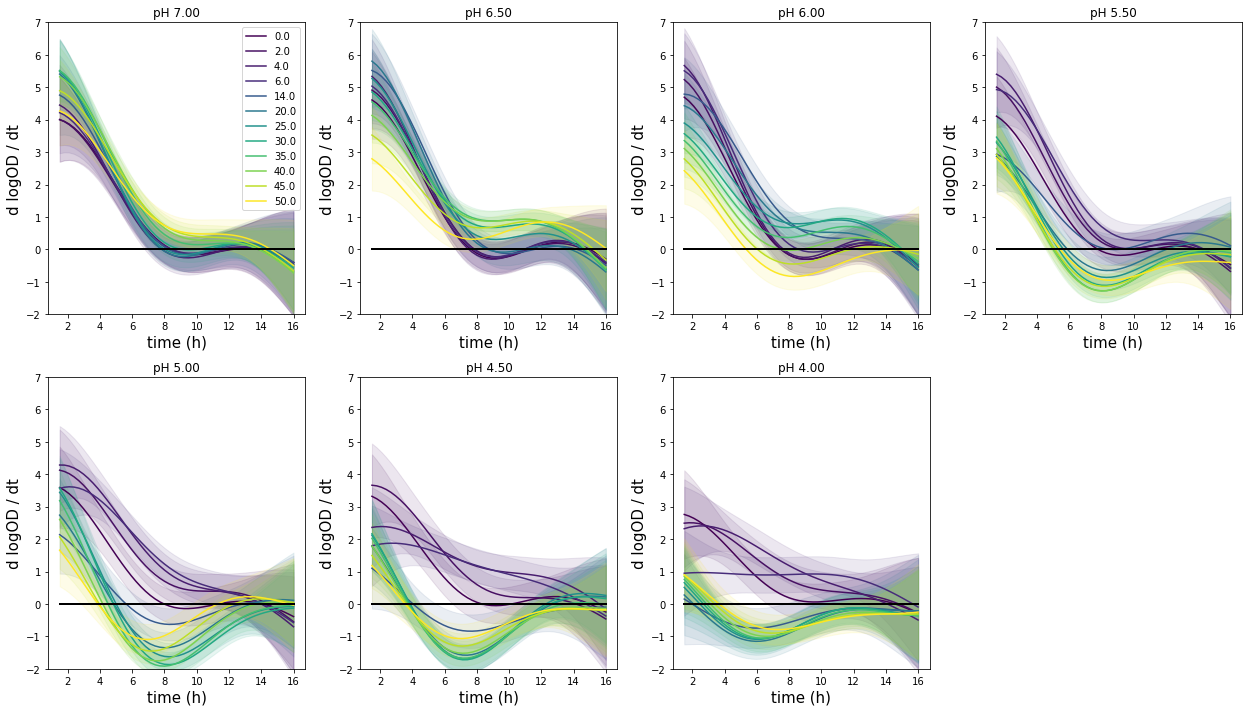

In [277]:
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, ds.meta.pH.unique().shape[0]*5))
# plt.figure(figsize=(ds.meta.propionicAcidmM.unique().shape[0]*5, 5))

nrow = 2
plt.figure(figsize=(ds.meta.pH.unique().shape[0]*5./nrow, 5*nrow))

for i,ph in enumerate(np.log10(ds.meta.pH.unique())):
    for j,pa in enumerate(np.log10(ds.meta.propionicAcidmM.unique() + 1e-1)):
        
        #plt.subplot(ds.meta.pH.unique().shape[0], ds.meta.propionicAcidmM.unique().shape[0], i*ds.meta.propionicAcidmM.unique().shape[0] +j + 1)
        
        #plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], j + 1)
        plt.subplot(nrow, ds.meta.pH.unique().shape[0]/nrow + 1, i + 1)
        
        #plt.title(((10**ph).round(), (10**pa-1e-1).round()))
        #plt.title((10**pa).round())
        plt.title("pH %.2lf"%((10**ph)))
        
        xpred[:,1:] = ph, pa

        mu,cov = gp.predict_noiseless(xpred,kern=kernDeriv,full_cov=False)
        mu = mu[:,0]#[:,0]
        
        #cov = cov-cov.min()
        cov = cov[:,0]
        #std = np.sqrt(cov.diagonal())
        std = np.sqrt(cov)
        
        color = plt.get_cmap()(((10.**pa))/50)

        plt.plot(xpred[:,0],mu, label = np.round(10**pa - 1e-1,1),c=color)
        plt.fill_between(xpred[:,0], mu-2*std, mu+2*std,alpha=.1,color=color)
        plt.plot([x.min(), x.max()], [0,0], lw=2, c='k')
        plt.ylim(-2,7)
        plt.ylabel("d logOD / dt",fontsize=15)
        plt.xlabel("time (h)",fontsize=15)
        
        
# plt.subplot(1, ds.meta.propionicAcidmM.unique().shape[0], 1)
plt.subplot(nrow, ds.meta.pH.unique().shape[0]/nrow + 1, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("figures/lund/ecoli-gp-byPh-derivative.pdf",bbox_inches='tight')

In [149]:
mu,cov = gp.predict_noiseless(xpred,kern=kernDeriv)

In [150]:
cov

array([[-15.44931533],
       [-15.53073243],
       [-15.63263563],
       [-15.75235988],
       [-15.88580978],
       [-16.02795666],
       [-16.17334779],
       [-16.3165864 ],
       [-16.45274759],
       [-16.57770415],
       [-16.68834682],
       [-16.7826949 ],
       [-16.85990277],
       [-16.92017691],
       [-16.96462334],
       [-16.99504881],
       [-17.01373904],
       [-17.02323501],
       [-17.02612409],
       [-17.0248577 ],
       [-17.0216017 ],
       [-17.01812117],
       [-17.01569772],
       [-17.01507563],
       [-17.01643297],
       [-17.01937496],
       [-17.02294882],
       [-17.02568175],
       [-17.02564522],
       [-17.02054965],
       [-17.00787258],
       [-16.98502115],
       [-16.94952551],
       [-16.89925495],
       [-16.83264317],
       [-16.74890393],
       [-16.64821513],
       [-16.53184763],
       [-16.40221637],
       [-16.26283565],
       [-16.11816711],
       [-15.9733583 ],
       [-15.83388034],
       [-15

In [11]:
ds = gpfanova.dataset.DataSet('data/normalized/lund/ecoli-replicate/')

temp = ds.meta.position.str.extract('([A-Z]?)([0-9]{1,2})\.?[0-9]?')
temp.columns = ['row','column']

row = None
for i,r in temp.iterrows():
    if r.row != '':
        row = r.row
    else:
         temp.loc[i,'row'] = row
            
ds.meta = temp

x,y,effect,labels = ds.build(effects=['row','column'],scale='range')
# y = (y-y.mean())/y.std()

dm = np.ones((y.shape[1],1))

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [110]:
effect

row  column
0     0       0
1     0       1
2     0       2
3     0       3
4     0       4
5     0       5
6     0       6
7     0       7
8     0       8
9     0       9
10    0      10
11    0      11
12    1       0
13    1       1
14    1       2
15    1       3
16    1       4
17    1       5
18    1       6
19    1       7
20    1       8
21    1       9
22    1      10
23    1      11
24    2       0
25    2       1
26    2       2
27    2       3
28    2       4
29    2       5
..  ...     ...
54    4       6
55    4       7
56    4       8
57    4       9
58    4      10
59    4      11
60    5       0
61    5       1
62    5       2
63    5       3
64    5       4
65    5       5
66    5       6
67    5       7
68    5       8
69    5       9
70    5      10
71    5      11
72    6       0
73    6       1
74    6       2
75    6       3
76    6       4
77    6       5
78    6       6
79    6       7
80    6       8
81    6       9
82    6      10
83    6      11

[84 rows x 2 columns]

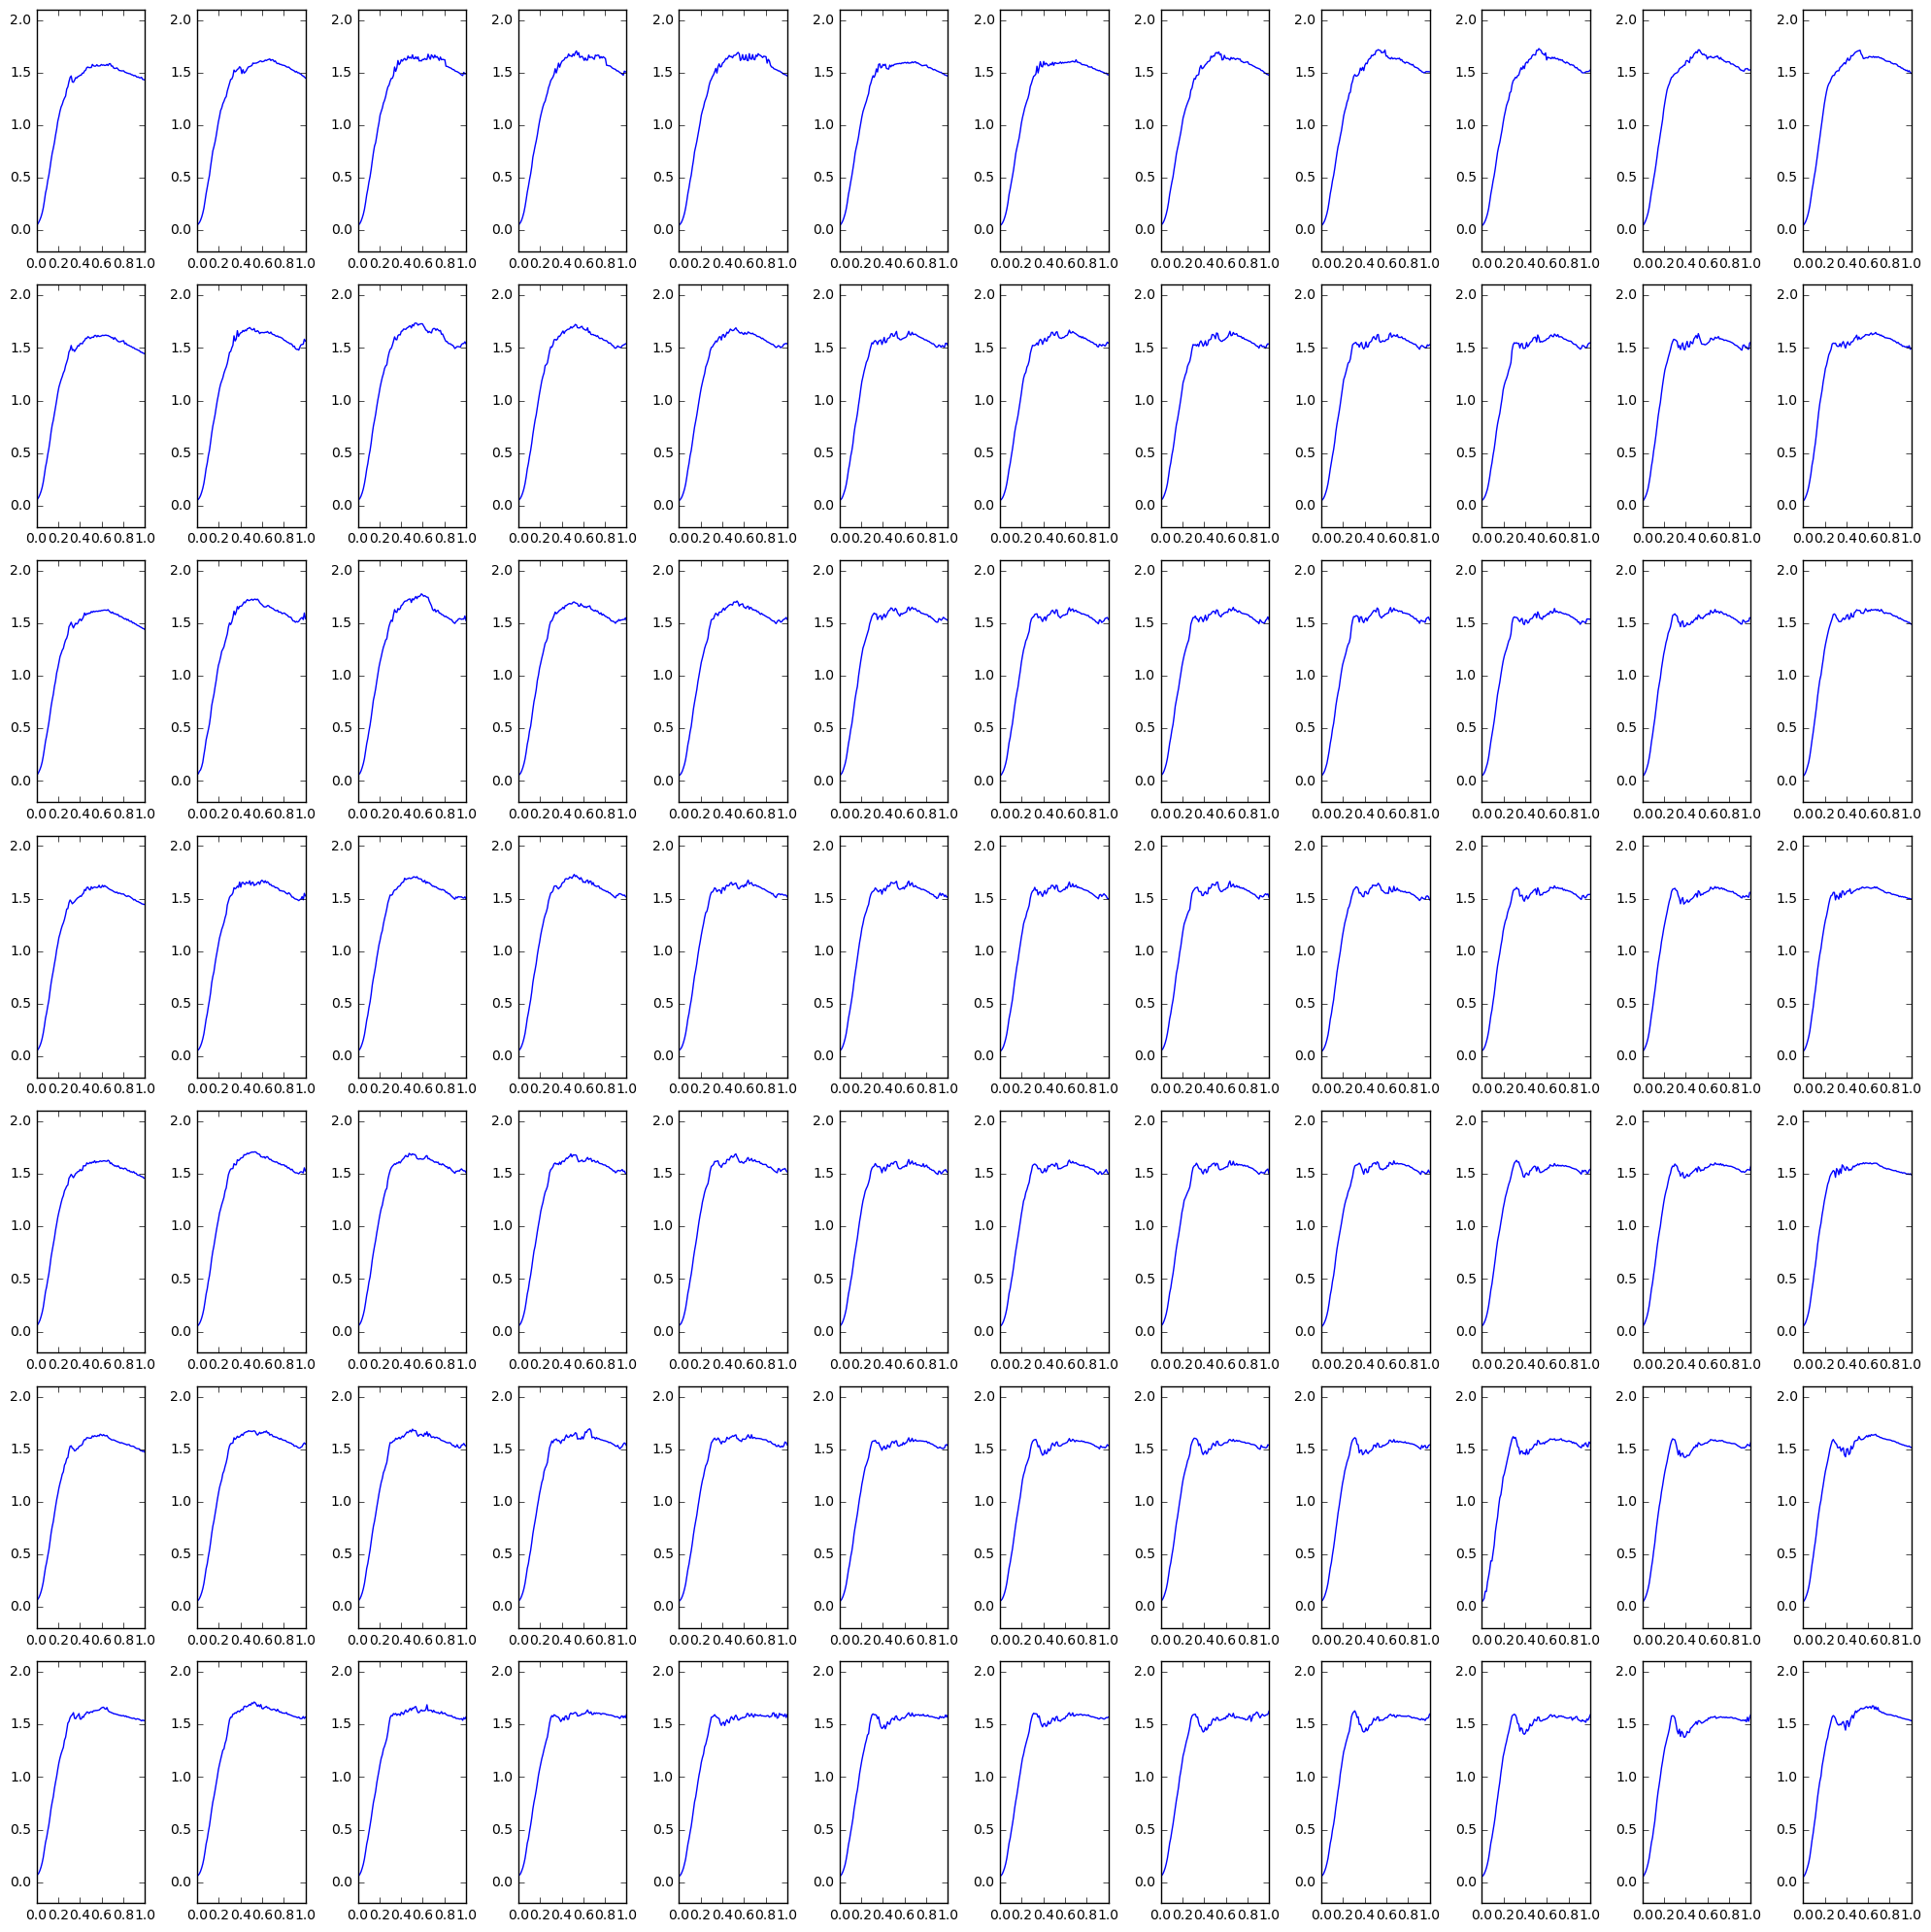

In [114]:
plt.figure(figsize=(20,20))

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        #plt.title("pH=%s,\nPAmM=%s"%(labels[0][i],labels[1][j]))
        select = (effect.values[:,0] == i) & (effect.values[:,1] == j)
        plt.plot(x,y[:,select]);
        
        plt.ylim(-.2,2.1)
        
plt.tight_layout()

plt.savefig("figures/lund/ecoli-replicate.png",dpi=300,bbox_inches='tight')

# Pseudomonas

In [66]:
ds = gpfanova.dataset.DataSet('data/normalized/lund/pseudomonas/')

sortby = ['acid','pH','mM-acid']
ds.data = ds.data.iloc[:,ds.meta.sort(sortby).index]
ds.meta = ds.meta.sort(sortby)

ds.data.columns = range(ds.data.shape[1])
ds.meta.index = range(ds.data.shape[1])

# x,y,effect,labels = ds.build(scale='range',effects=['pH','mM lactic acid','strain'])
x,y,effect,labels = ds.build(effects=['pH','mM-acid','strain'],acid='acetic')

# ind = 4
# x = x[4:,:]
# y = y[4:,:]
# y = np.log2(y)
# y = y-y[0,:]

# y = (y-y.mean())/y.std()

dm = np.ones((y.shape[1],1))

/home/ptonner/dev/combinatorial-growth/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/ptonner/dev/combinatorial-growth/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


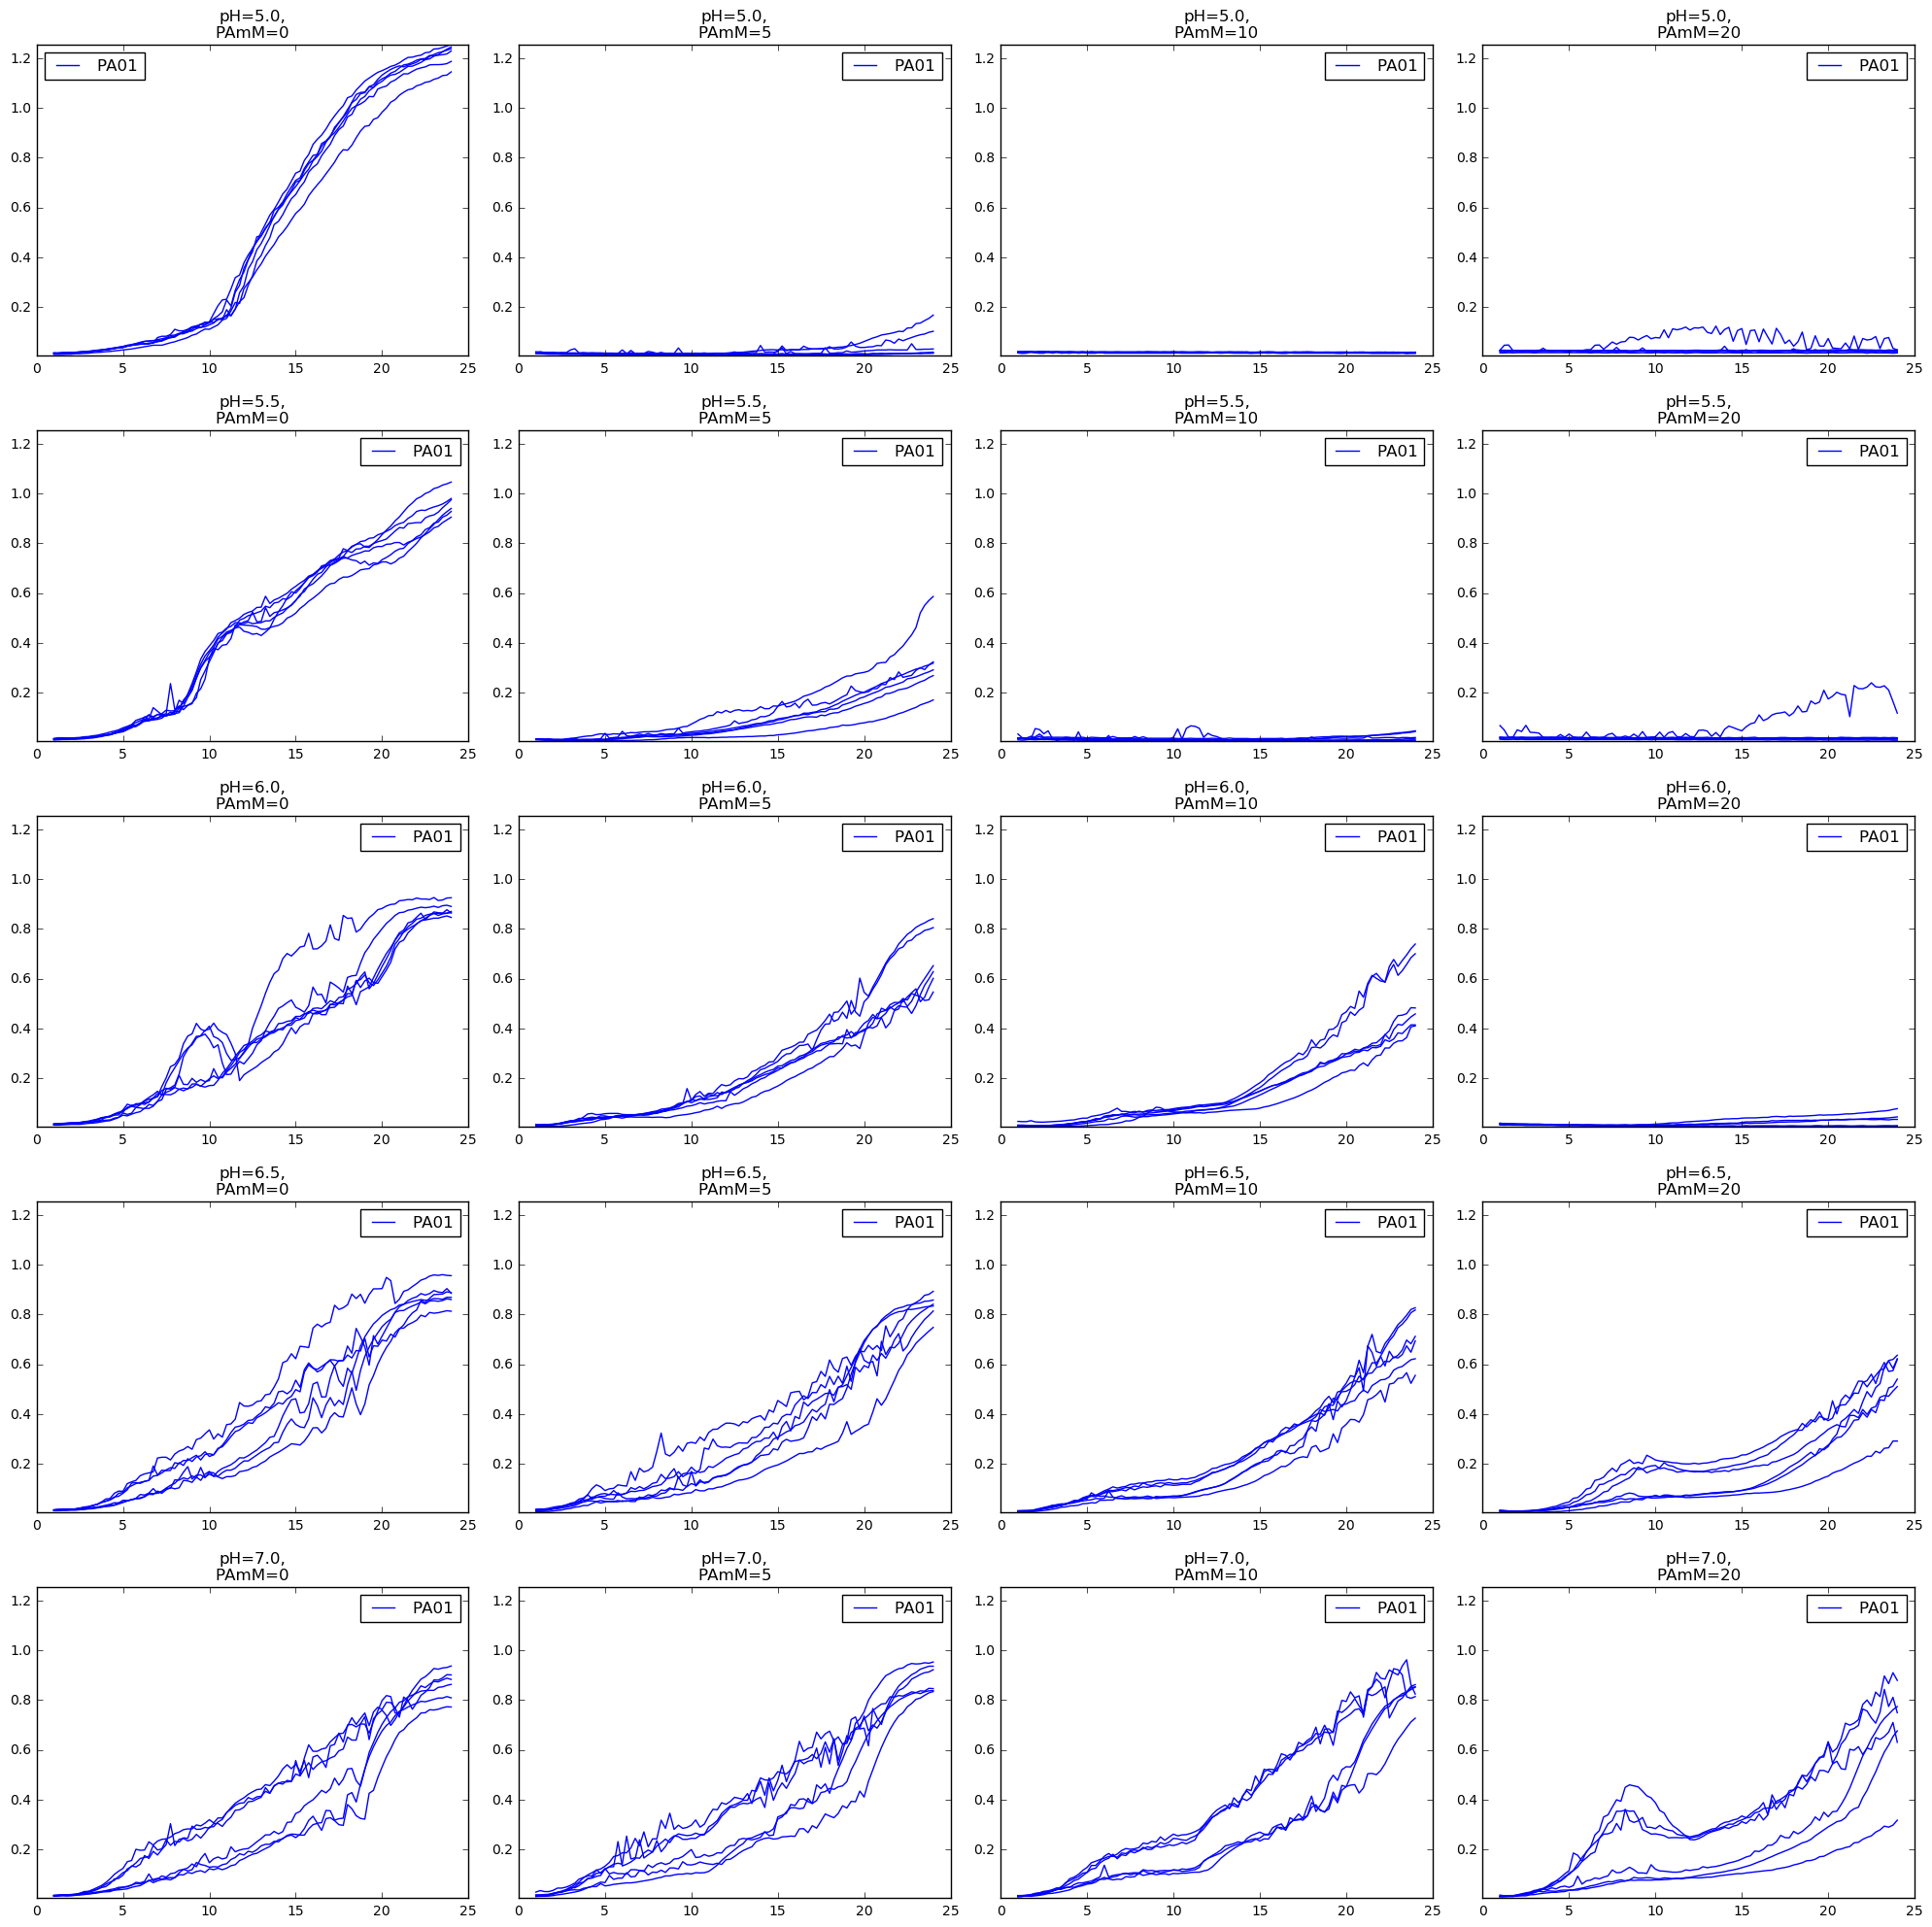

In [58]:
plt.figure(figsize=(20,20))

colors = ['b','g']

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        plt.title("pH=%s,\nPAmM=%s"%(labels[0][i],labels[1][j]))
        
        for k in np.unique(effect.values[:,2]):
            select = (effect.values[:,0] == i) & (effect.values[:,1] == j) & (effect.values[:,2] == k)
            
            for ii,jj in enumerate(np.where(select)[0]):
                l = None
                if ii == 0:
                    l = labels[2][k]
                plt.plot(x,y[:,jj],c=colors[k],label=l);
            
            #plt.plot(x,y[:,select],c=colors[k],label=labels[2][k]);

            plt.ylim(y.min(),y.max())
            plt.legend(loc='best')
        
plt.tight_layout()

plt.savefig("figures/lund/pseudomonas-acetic-unlogged.png",dpi=300,bbox_inches='tight')

In [69]:
x,y,effect,labels = ds.build(effects=['pH','mM-acid','batch'],acid='acetic')

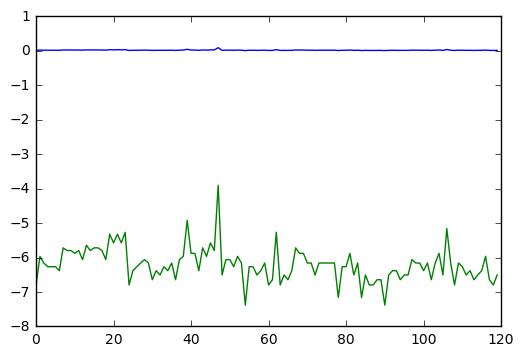

In [70]:
plt.plot(np.log2(y[0,:]+1e-0))
plt.plot(np.log2(y[0,:]))

In [71]:
# ind = 4
# x = x[ind:,:]
# y = y[ind:,:]

y = np.log2(y+1e0)
y = y-y[0,:]

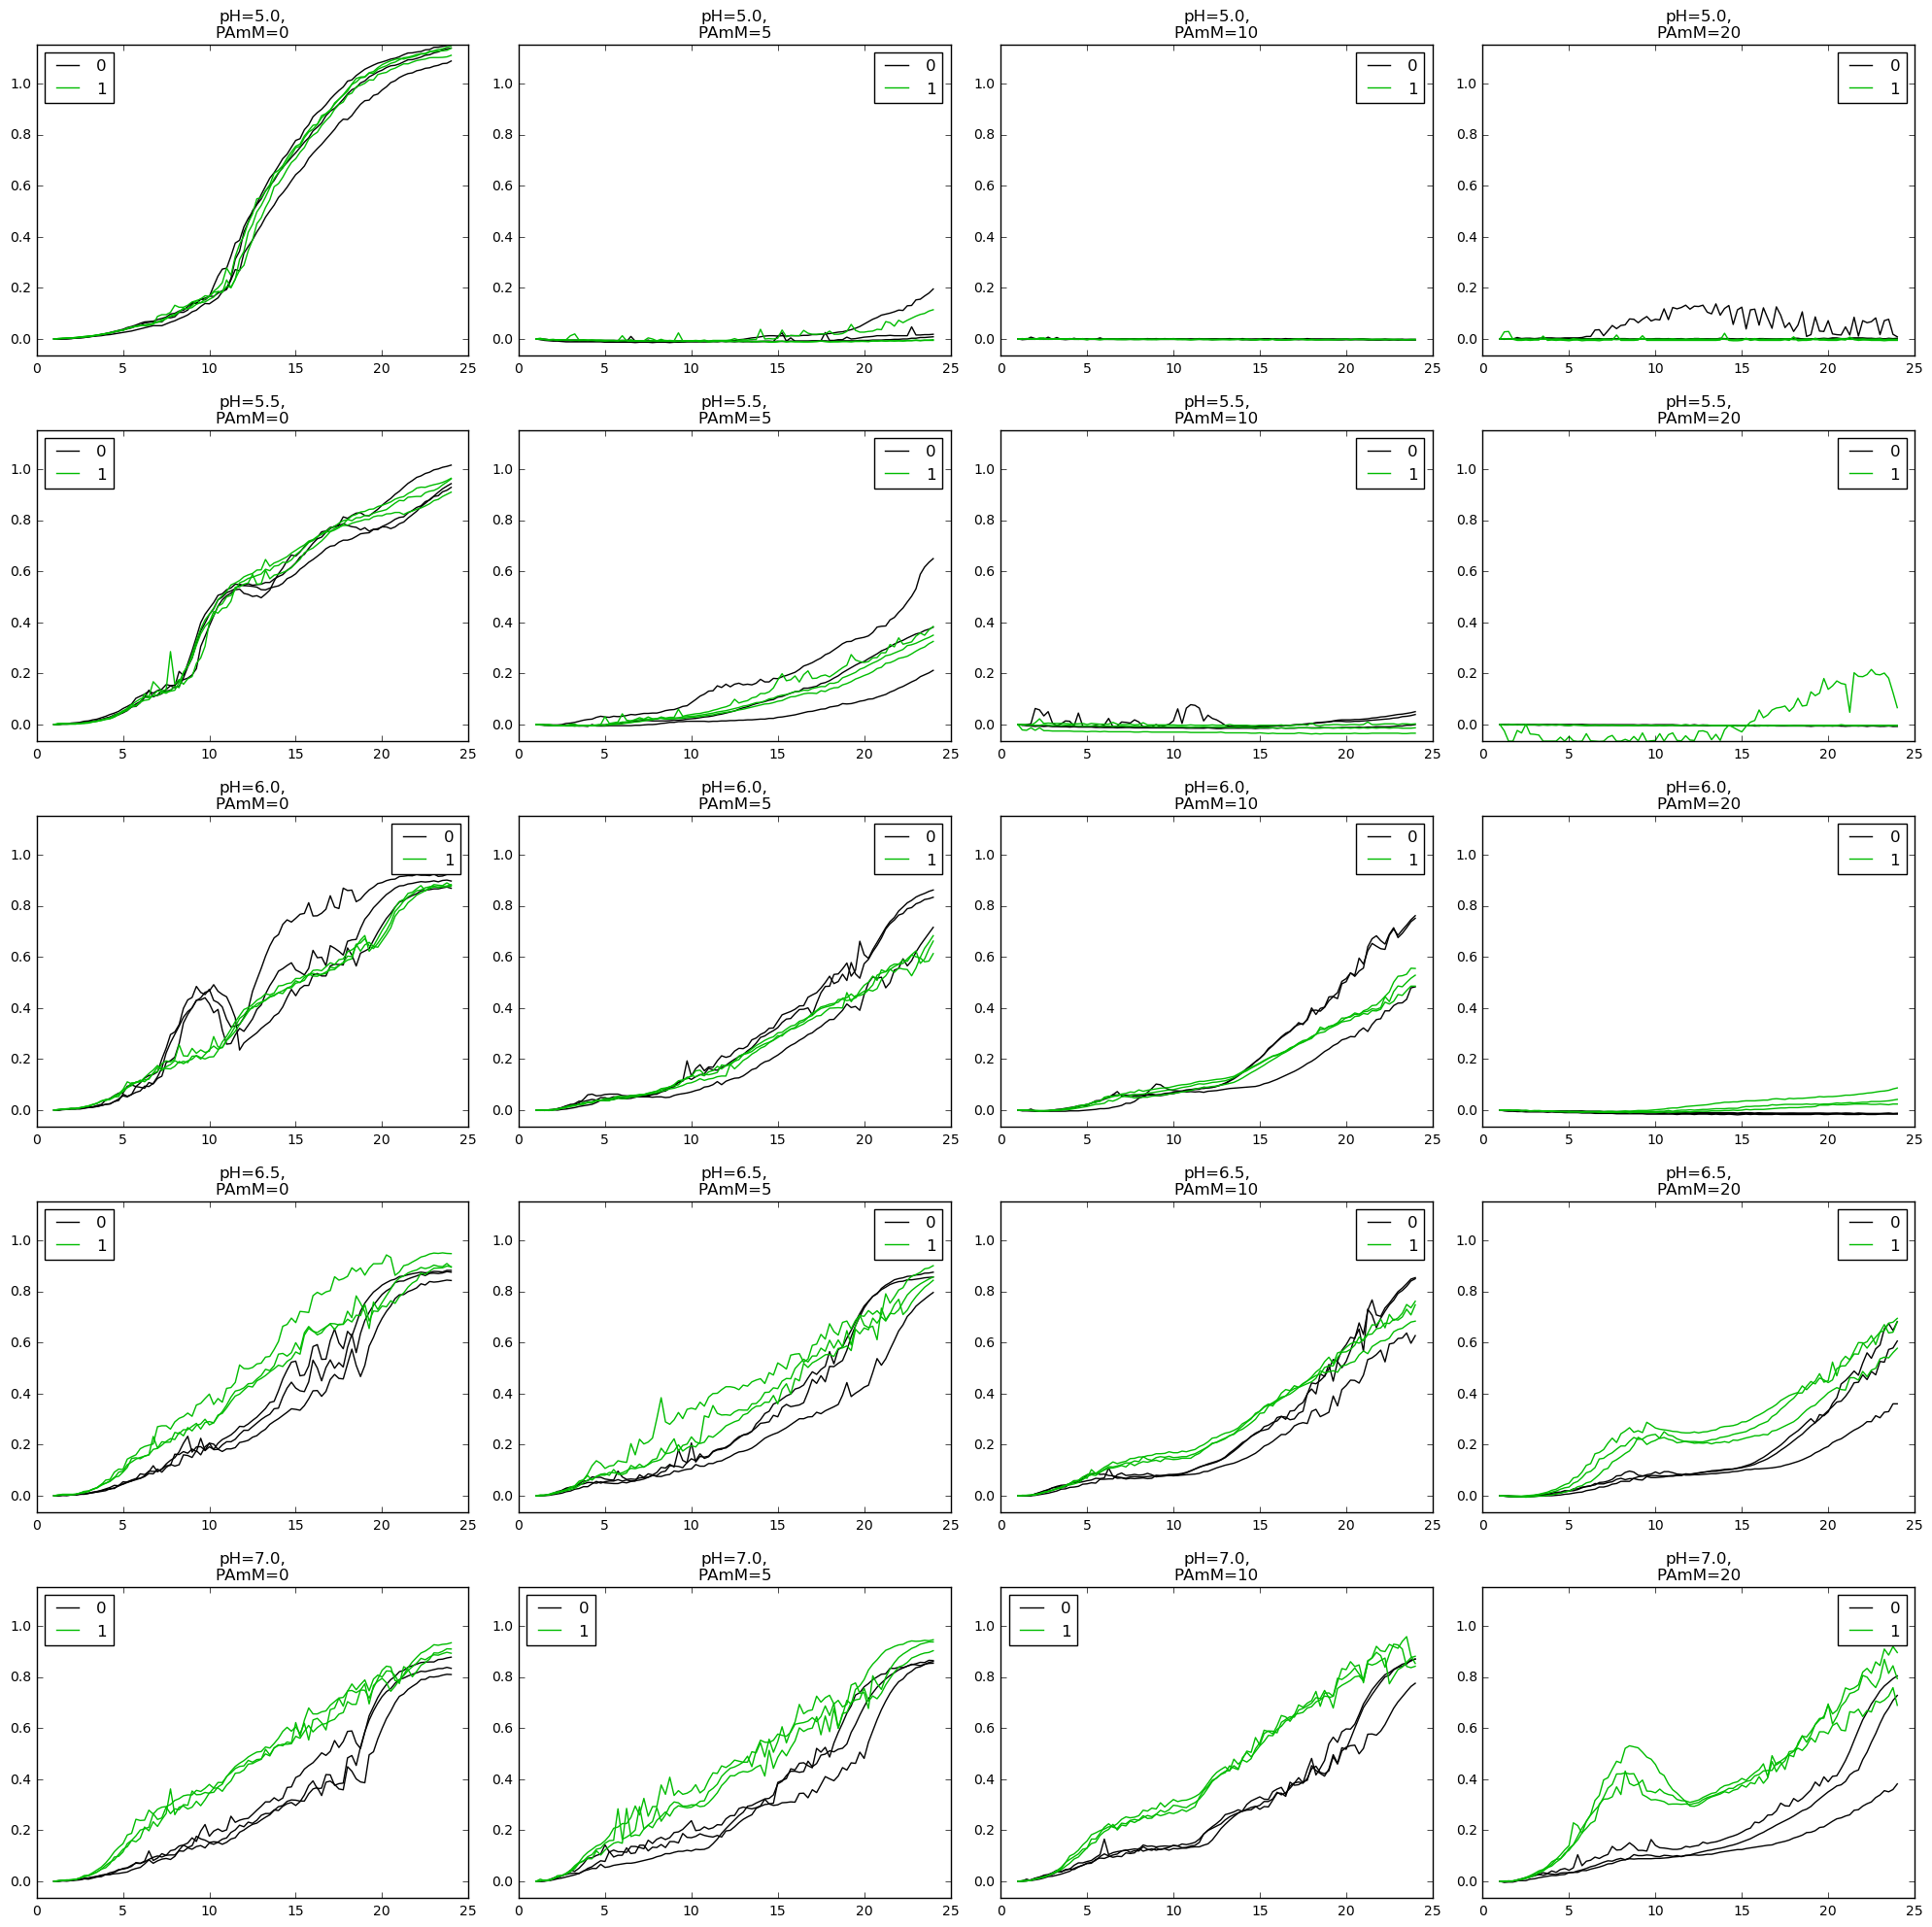

In [72]:
plt.figure(figsize=(20,20))

cmap = plt.get_cmap('spectral')
colors = [cmap(1.*i/2) for i in range(2)]

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        plt.title("pH=%s,\nPAmM=%s"%(labels[0][i],labels[1][j]))
        
        for k in np.unique(effect.values[:,2]):
            select = (effect.values[:,0] == i) & (effect.values[:,1] == j) & (effect.values[:,2] == k)
            
            for ii,jj in enumerate(np.where(select)[0]):
                l = None
                if ii == 0:
                    l = labels[2][k]
                plt.plot(x,y[:,jj],c=colors[k],label=l);
            
            #plt.plot(x,y[:,select],c=colors[k],label=labels[2][k]);

            plt.ylim(y.min(),y.max())
            plt.legend(loc='best')
        
plt.tight_layout()

plt.savefig("figures/lund/pseudomonas-acetic.png",dpi=300,bbox_inches='tight')

In [81]:
x,y,effect,labels = ds.build(effects=['pH','mM-acid','batch'],acid='propionic')

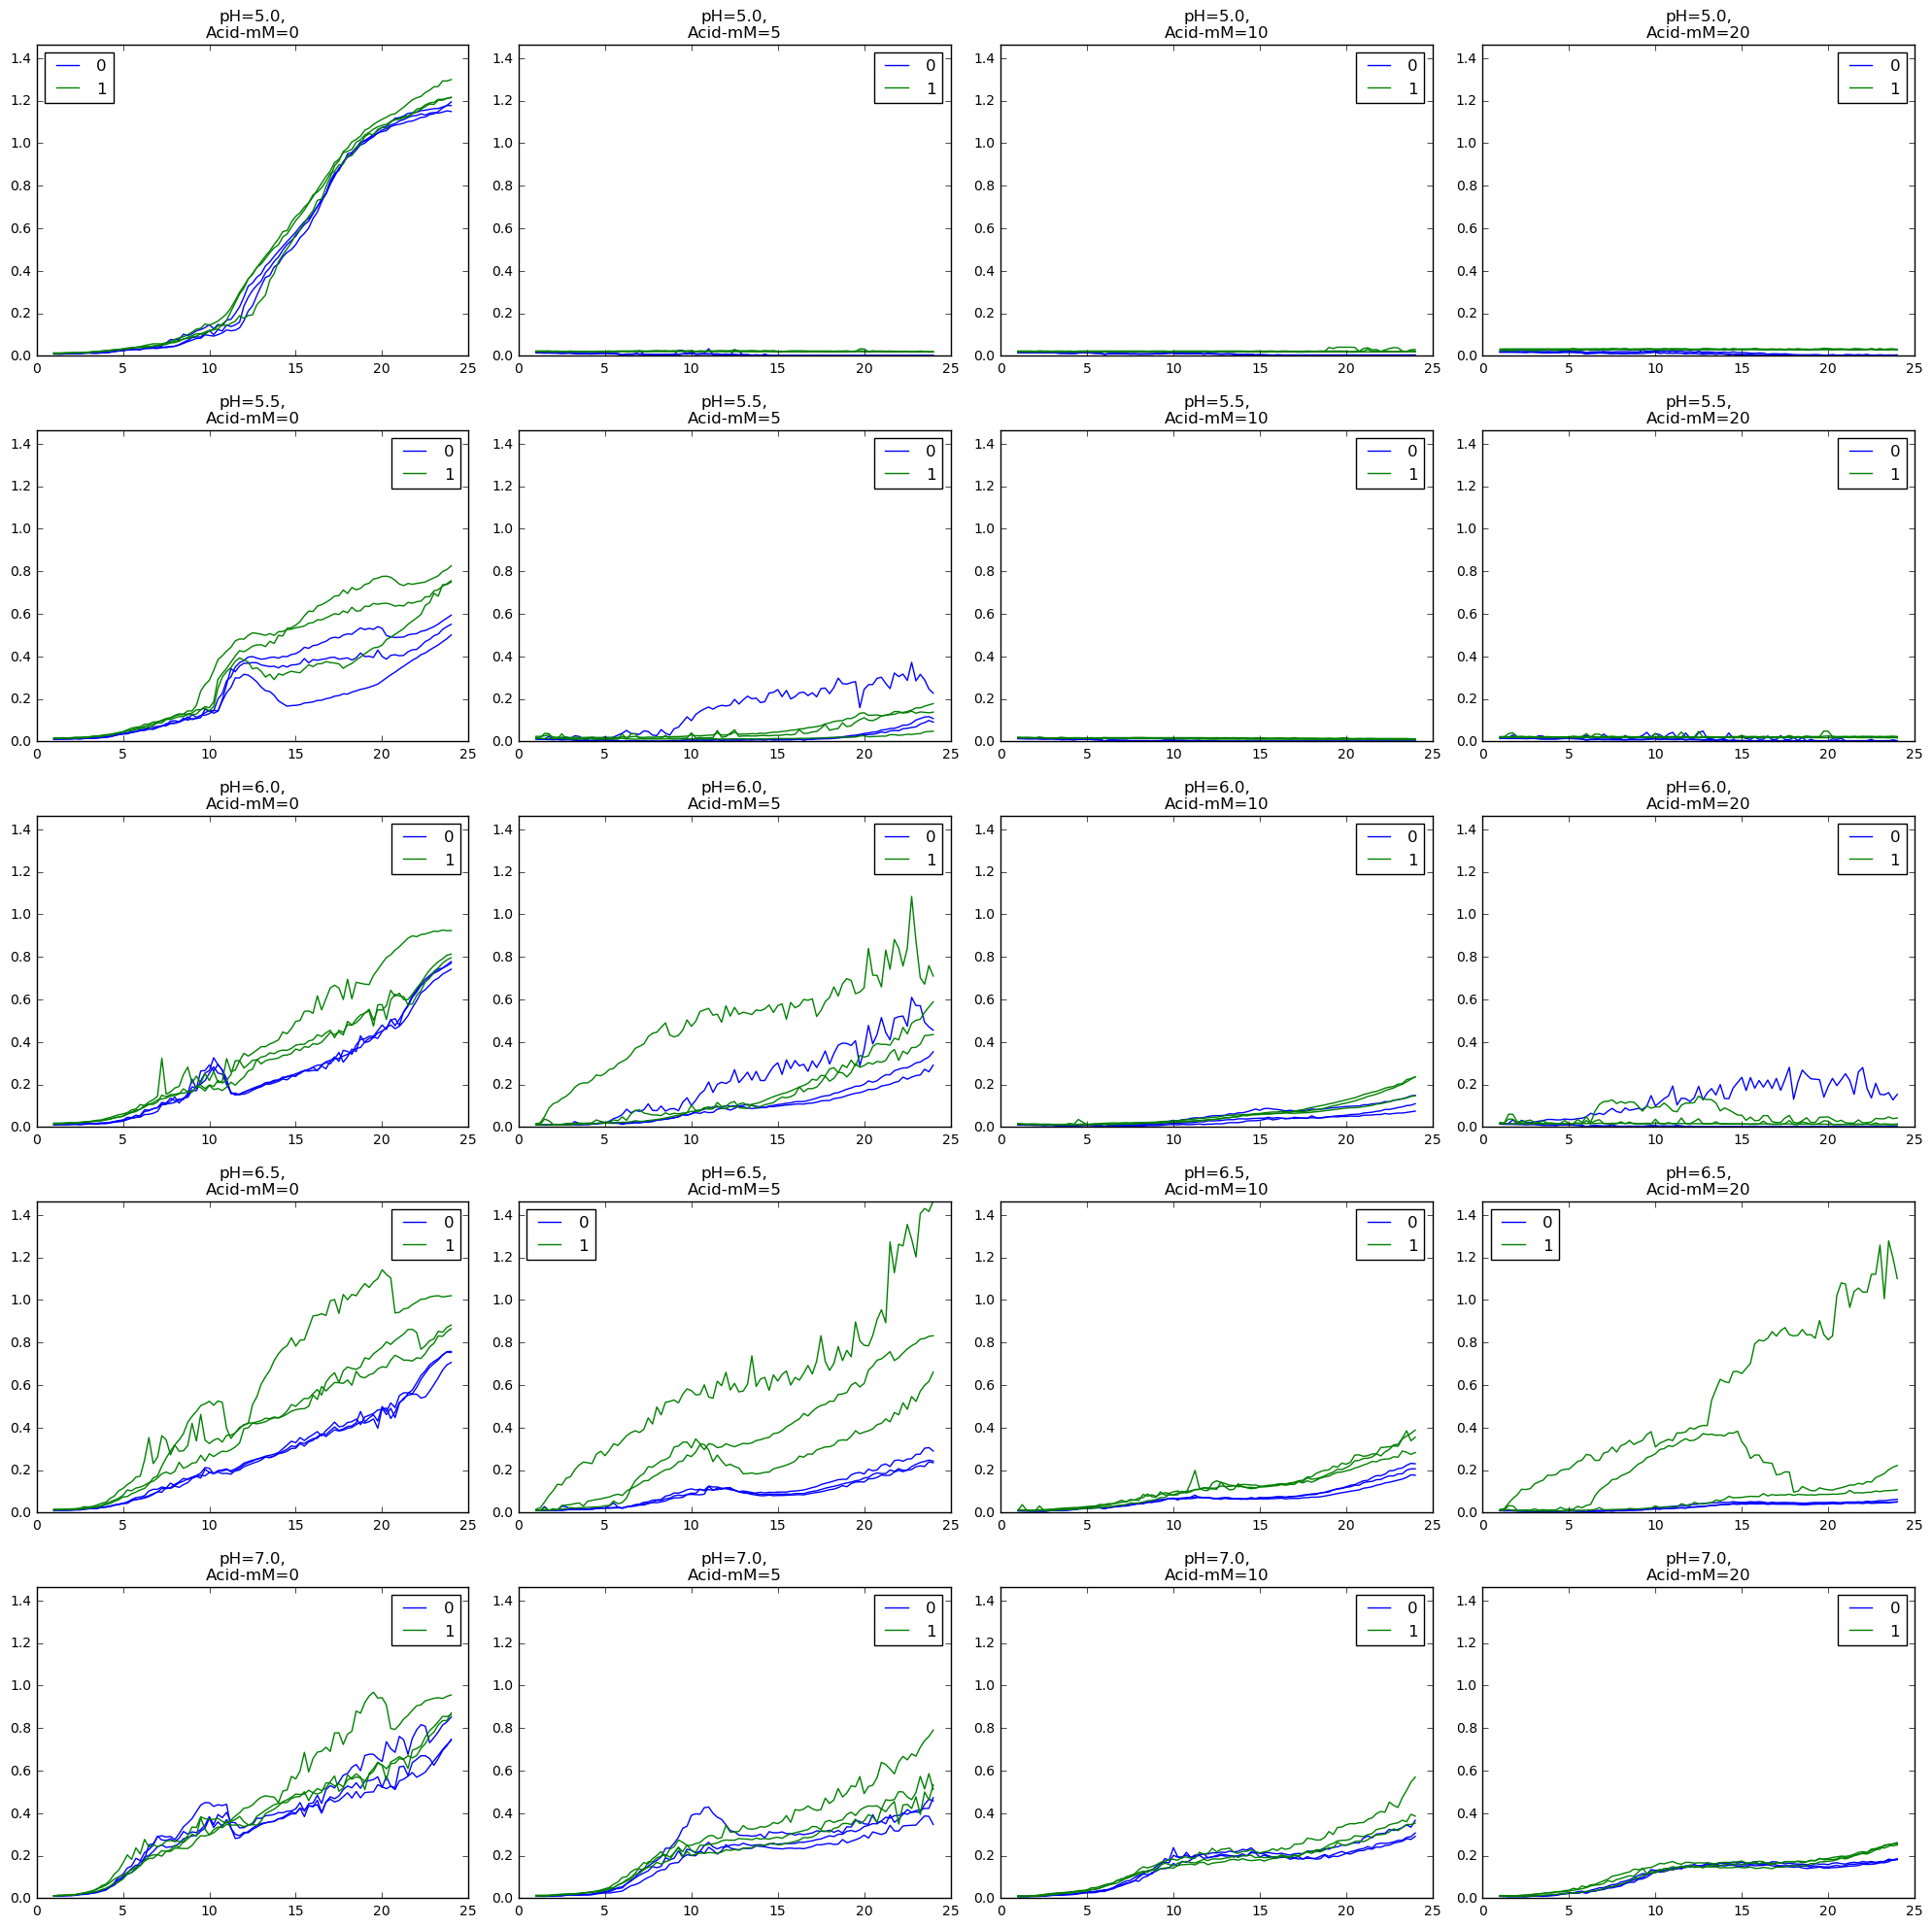

In [82]:
plt.figure(figsize=(20,20))

colors = ['b','g']

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        plt.title("pH=%s,\nAcid-mM=%s"%(labels[0][i],labels[1][j]))
        
        for k in np.unique(effect.values[:,2]):
            select = (effect.values[:,0] == i) & (effect.values[:,1] == j) & (effect.values[:,2] == k)
            
            for ii,jj in enumerate(np.where(select)[0]):
                l = None
                if ii == 0:
                    l = labels[2][k]
                plt.plot(x,y[:,jj],c=colors[k],label=l);
            
            #plt.plot(x,y[:,select],c=colors[k],label=labels[2][k]);

            plt.ylim(y.min(),y.max())
            plt.legend(loc='best')
        
plt.tight_layout()

plt.savefig("figures/lund/pseudomonas-propionic-unlogged.png",dpi=300,bbox_inches='tight')

In [83]:
# ind = 4
# x = x[ind:,:]
# y = y[ind:,:]

y = np.log2(y+1e0)
y = y-y[0,:]

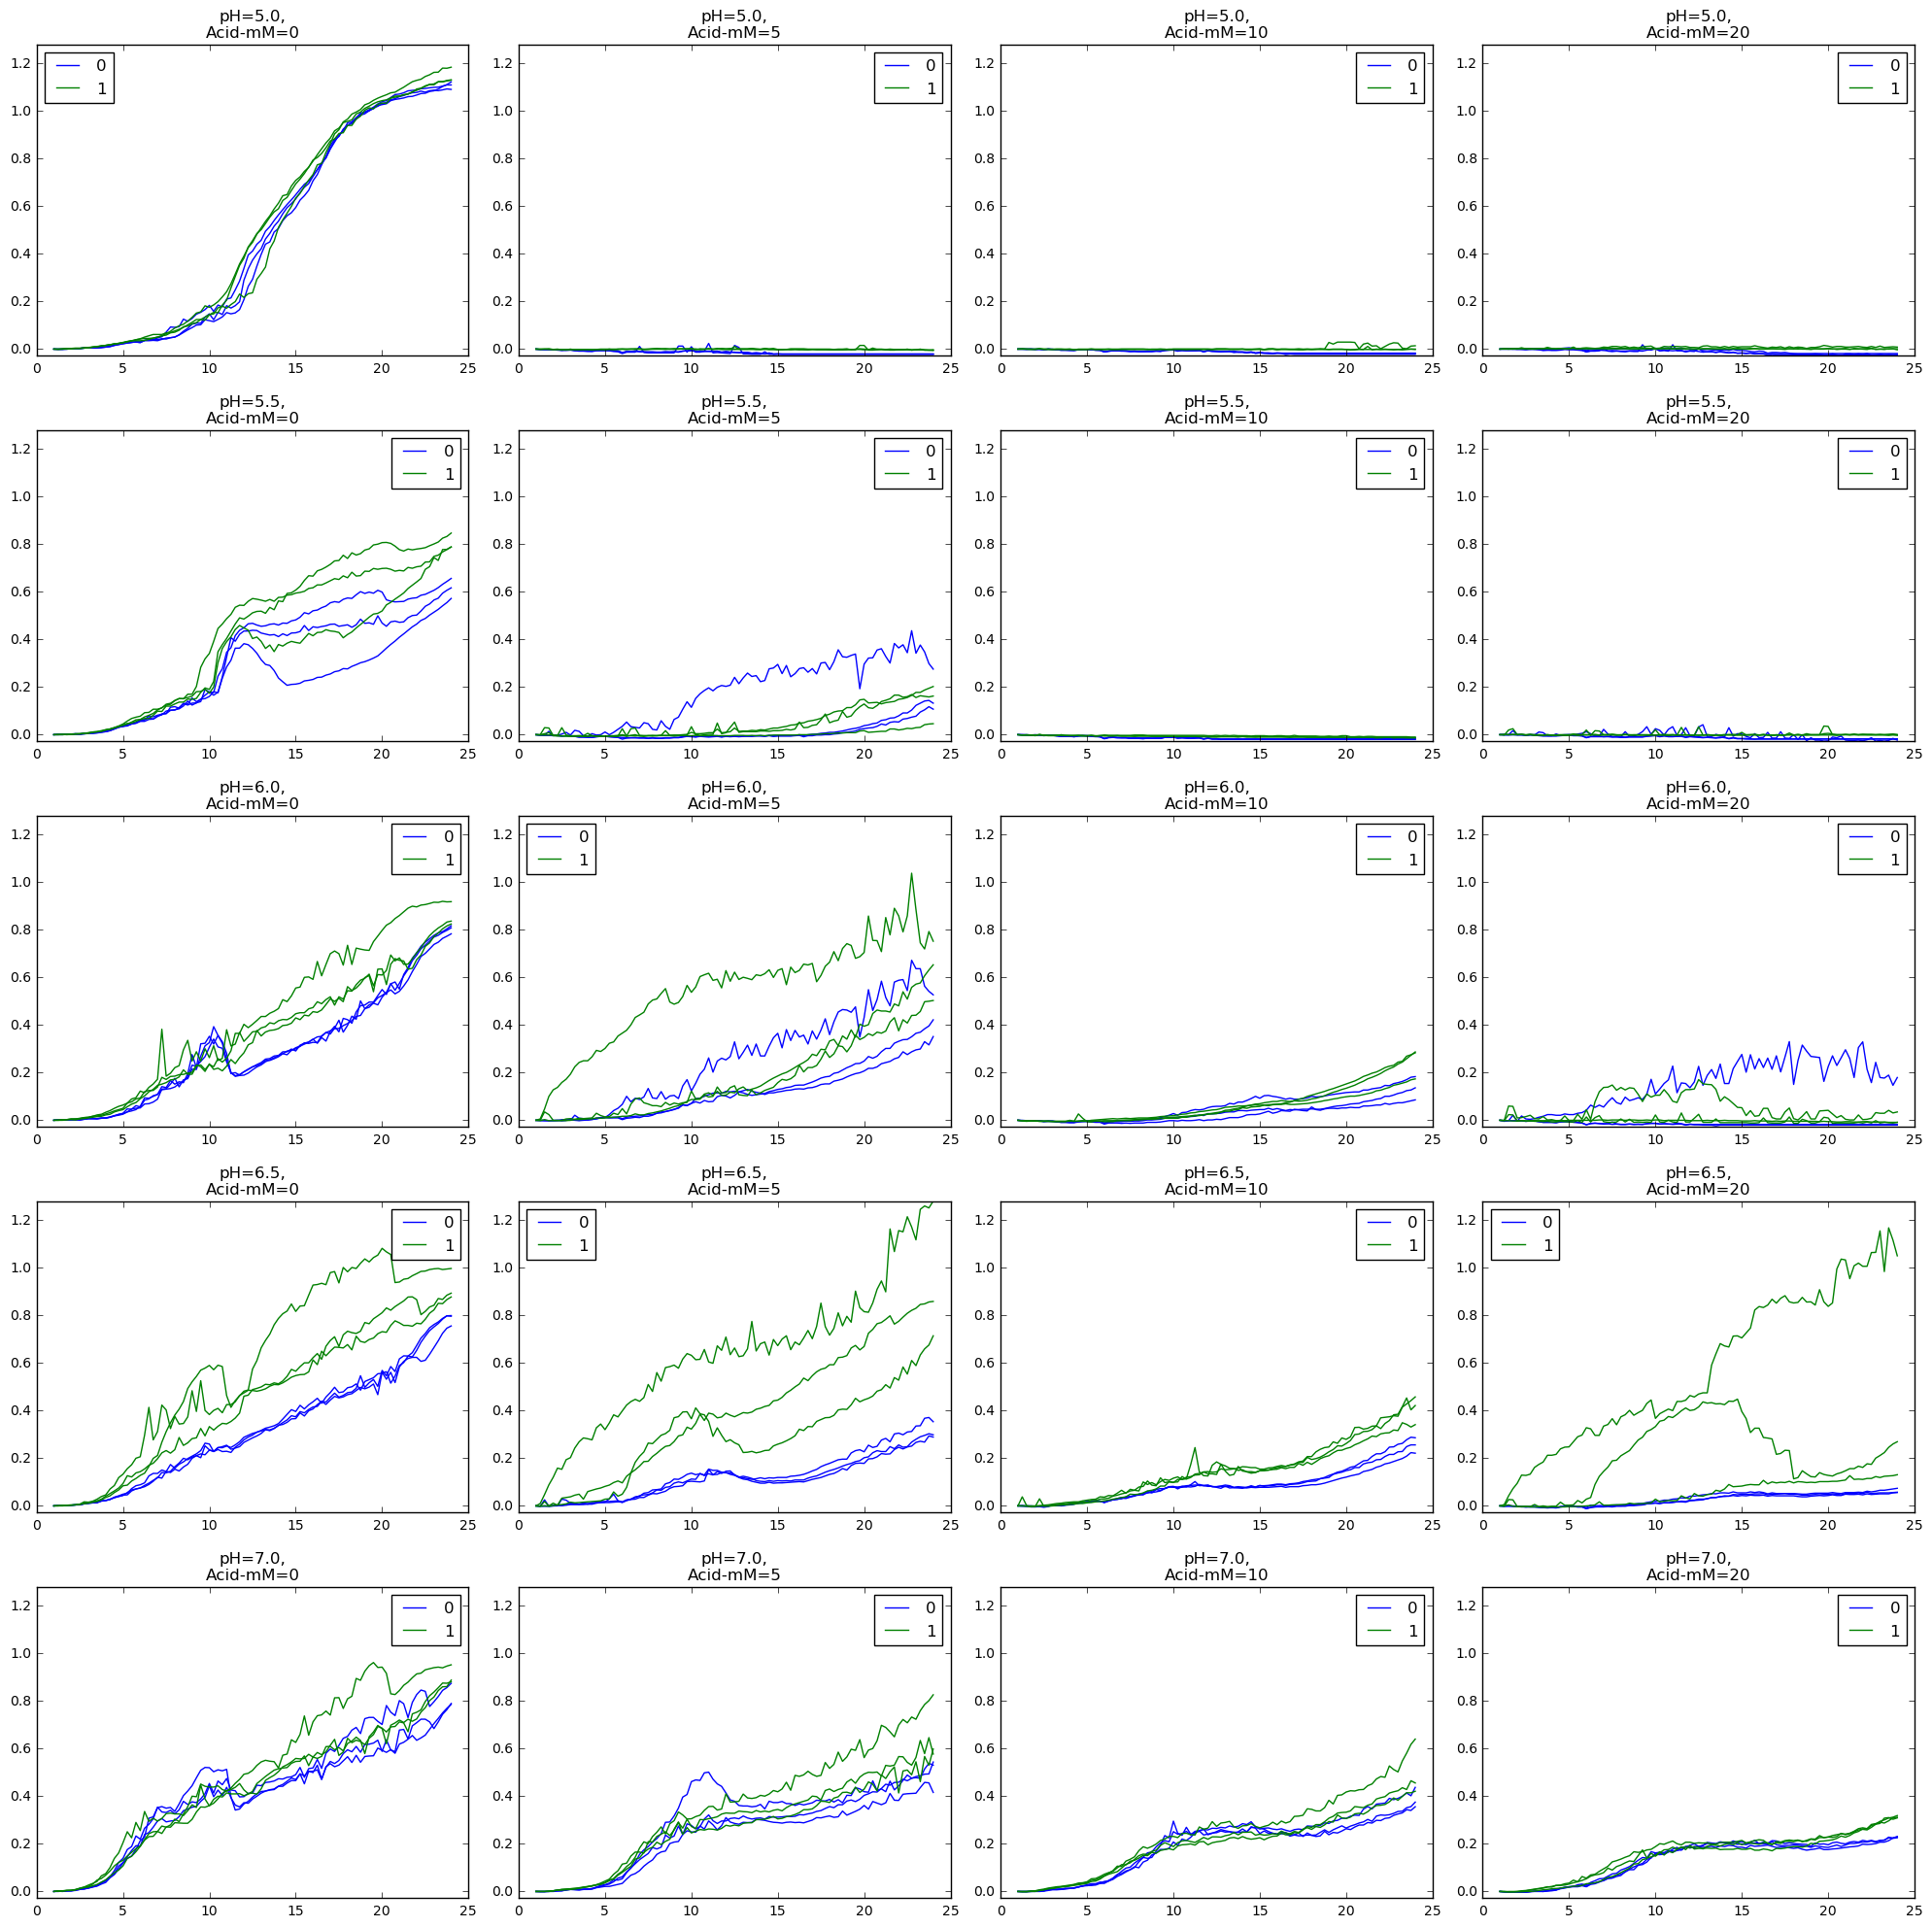

In [84]:
plt.figure(figsize=(20,20))

colors = ['b','g']

for i in np.unique(effect.values[:,0]):
    for j in np.unique(effect.values[:,1]):
        plt.subplot(len(labels[0]),len(labels[1]),i*len(labels[1])+j+1)
        plt.title("pH=%s,\nAcid-mM=%s"%(labels[0][i],labels[1][j]))
        
        for k in np.unique(effect.values[:,2]):
            select = (effect.values[:,0] == i) & (effect.values[:,1] == j) & (effect.values[:,2] == k)
            
            for ii,jj in enumerate(np.where(select)[0]):
                l = None
                if ii == 0:
                    l = labels[2][k]
                plt.plot(x,y[:,jj],c=colors[k],label=l);
            
            #plt.plot(x,y[:,select],c=colors[k],label=labels[2][k]);

            plt.ylim(y.min(),y.max())
            plt.legend(loc='best')
        
plt.tight_layout()

plt.savefig("figures/lund/pseudomonas-propionic.png",dpi=300,bbox_inches='tight')